<a href="https://www.kaggle.com/code/taylortyler/using-lightgbm-and-catboost?scriptVersionId=134401788" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
from sklearn import svm
import tensorflow as tf
from tensorflow.keras import layers
from datetime import date, datetime
from sklearn.base import BaseEstimator

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
df_train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col=[0])
df_test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col=[0])
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv', index_col=[0])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


# Exploratory Data Analysis

In [2]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 617 entries, 000ff2bfdfe9 to ffcca4ded3bb
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      617 non-null    float64
 1   AF      617 non-null    float64
 2   AH      617 non-null    float64
 3   AM      617 non-null    float64
 4   AR      617 non-null    float64
 5   AX      617 non-null    float64
 6   AY      617 non-null    float64
 7   AZ      617 non-null    float64
 8   BC      617 non-null    float64
 9   BD      617 non-null    float64
 10  BN      617 non-null    float64
 11  BP      617 non-null    float64
 12  BQ      557 non-null    float64
 13  BR      617 non-null    float64
 14  BZ      617 non-null    float64
 15  CB      615 non-null    float64
 16  CC      614 non-null    float64
 17  CD      617 non-null    float64
 18  CF      617 non-null    float64
 19  CH      617 non-null    float64
 20  CL      617 non-null    float64
 21  CR      617 non-null    

In [3]:
df_train['EJ'].unique()

array(['B', 'A'], dtype=object)

In [4]:
greeks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 617 entries, 000ff2bfdfe9 to ffcca4ded3bb
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Alpha    617 non-null    object
 1   Beta     617 non-null    object
 2   Gamma    617 non-null    object
 3   Delta    617 non-null    object
 4   Epsilon  617 non-null    object
dtypes: object(5)
memory usage: 28.9+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 00eed32682bb to 046e85c7cc7f
Data columns (total 56 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      5 non-null      float64
 1   AF      5 non-null      float64
 2   AH      5 non-null      float64
 3   AM      5 non-null      float64
 4   AR      5 non-null      float64
 5   AX      5 non-null      float64
 6   AY      5 non-null      float64
 7   AZ      5 non-null      float64
 8   BC      5 non-null      float64
 9   BD      5 non-null      float64
 10  BN      5 non-null      float64
 11  BP      5 non-null      float64
 12  BQ      5 non-null      float64
 13  BR      5 non-null      float64
 14  BZ      5 non-null      float64
 15  CB      5 non-null      float64
 16  CC      5 non-null      float64
 17  CD      5 non-null      float64
 18  CF      5 non-null      float64
 19  CH      5 non-null      float64
 20  CL      5 non-null      float64
 21  CR      5 non-null      fl

<AxesSubplot: ylabel='Class'>

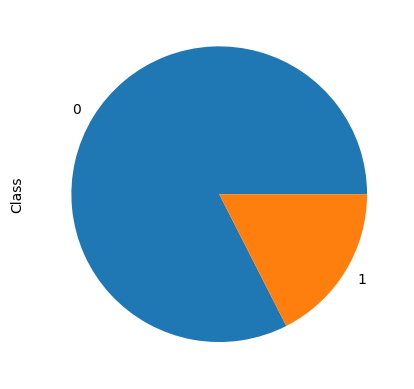

In [6]:
plot_df= df_train.Class.value_counts()
plot_df.plot(kind="pie")

In [7]:
# Calculate the number of negative and positive values in `Class` column
neg, pos = np.bincount(df_train['Class'])
# Calculate total samples
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 617
    Positive: 108 (17.50% of total)



In [8]:
df_train.isna().sum()

AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

# Preprocessing

In [9]:
print(df_test['EJ'].unique())

['A']


In [10]:
df_train['EJ'] = df_train['EJ'].replace({'A': 0, 'B': 1}).astype(int)
df_test['EJ'] = df_test['EJ'].replace({'A': 0, 'B': 1}).astype(int)

In [11]:
times = greeks.Epsilon.copy()
times[greeks.Epsilon != 'Unknown'] = greeks.Epsilon[greeks.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
times[greeks.Epsilon == 'Unknown'] = np.nan

In [12]:
target = 'Class'
predictors = [n for n in df_train.columns if n != target and n != 'Id']

In [13]:
train_cols_with_missing = [col for col in df_train.columns
                    if df_train[col].isnull().any()]

reduced_df_train = df_train.drop(train_cols_with_missing, axis=1)

In [14]:
im_df_train = df_train.drop(['Class'], axis=1).copy()
my_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(im_df_train),columns = my_imputer.get_feature_names_out())

In [15]:
reduced_rows_df_train = df_train.dropna()

# LightGBM

In [16]:
from sklearn.model_selection import StratifiedKFold

imputed_X_train.columns = imputed_X_train.columns.str.replace(' ', '_')
light_X = imputed_X_train
light_y = df_train['Class']

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 15,
    'learning_rate': 0.075,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Use stratified KFold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store accuracy for each fold
log_losses = []

for train_index, test_index in kf.split(light_X, light_y):
    light_X_train, light_X_test = light_X.iloc[train_index], light_X.iloc[test_index]
    light_y_train, light_y_test = light_y.iloc[train_index], light_y.iloc[test_index]

    train_data = lgb.Dataset(light_X_train, label=light_y_train)
    model = lgb.train(params, train_data, num_boost_round=100)
    light_y_pred = model.predict(light_X_test, num_iteration=model.best_iteration)
    light_y_pred_binary = [1 if prob > 0.8 else 0 for prob in light_y_pred]

    loss = log_loss(light_y_test, light_y_pred)
    log_losses.append(loss)

average_loss = sum(log_losses) / len(log_losses)
print("Average log loss: %.2f" % average_loss)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive ga

In [17]:
class_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_class': 1,
    'num_leaves': 40,
    'learning_rate': 0.075,
    'n_estimators': 50,
}

# Define the model
clf = lgb.LGBMClassifier(**class_params)

# Define 5-fold stratified cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_loss_scores = []
for train_index, test_index in kfold.split(light_X, light_y):
    lgb_X_train, lgb_X_test = light_X.iloc[train_index], light_X.iloc[test_index]
    lgb_y_train, lgb_y_test = light_y.iloc[train_index], light_y.iloc[test_index]
    
    # Train the model
    clf.fit(lgb_X_train, lgb_y_train)

    # Predict the test set results
    lgb_y_pred_proba = clf.predict_proba(lgb_X_test)

    # Calculate the log loss of the model
    logloss = log_loss(lgb_y_test, lgb_y_pred_proba)
    
    log_loss_scores.append(logloss)

average_log_loss = sum(log_loss_scores) / len(log_loss_scores)

print("Average Log Loss: %.2f" % average_log_loss)

Average Log Loss: 0.21


# CatBoost

In [18]:
cat_X = imputed_X_train
cat_y = df_train['Class']

cat_X_train, cat_X_test, cat_y_train, cat_y_test = train_test_split(cat_X, cat_y, test_size=0.3, random_state=42)

cat_model = CatBoostClassifier(iterations=100,
                           depth=5,
                           learning_rate=0.05,
                           loss_function='Logloss',
                           verbose=False)

cat_model.fit(cat_X_train, cat_y_train)

cat_preds_class = cat_model.predict(cat_X_test)

loss = log_loss(cat_y_test, cat_preds_class)
print("Log Loss: %.2f" % loss)

Log Loss: 1.74
